In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import time
import datetime
from dateutil.relativedelta import relativedelta
import os

In [2]:
%run ./Genetic_Lib.ipynb

In [ ]:
def remove_outlier(y):
    Q1 = np.percentile(y, 20,
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 80,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

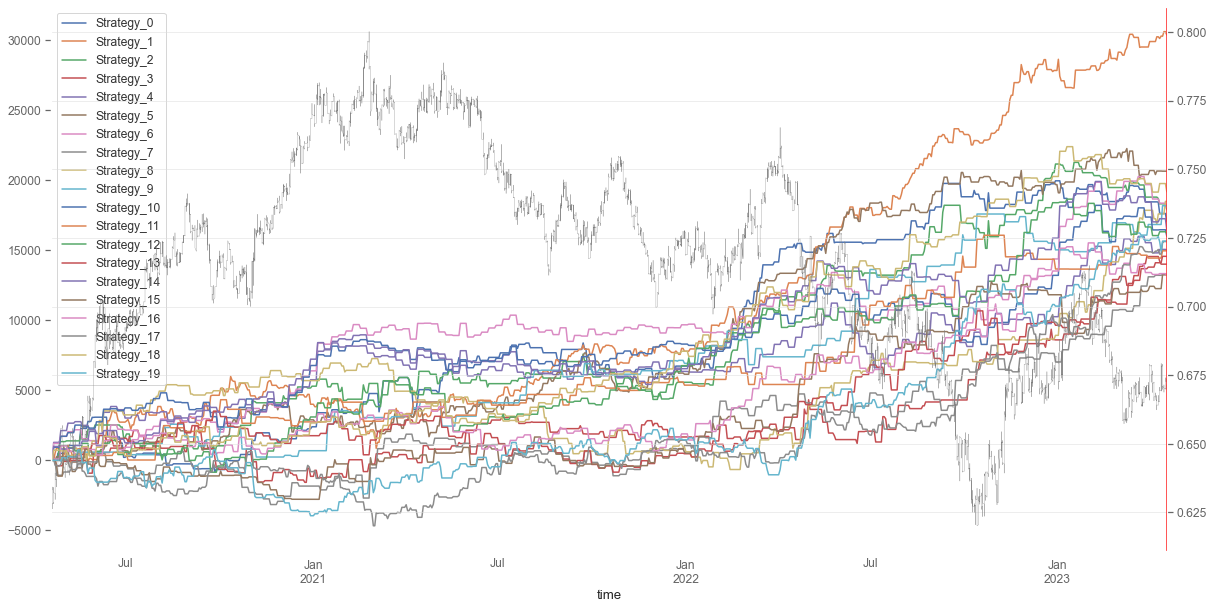

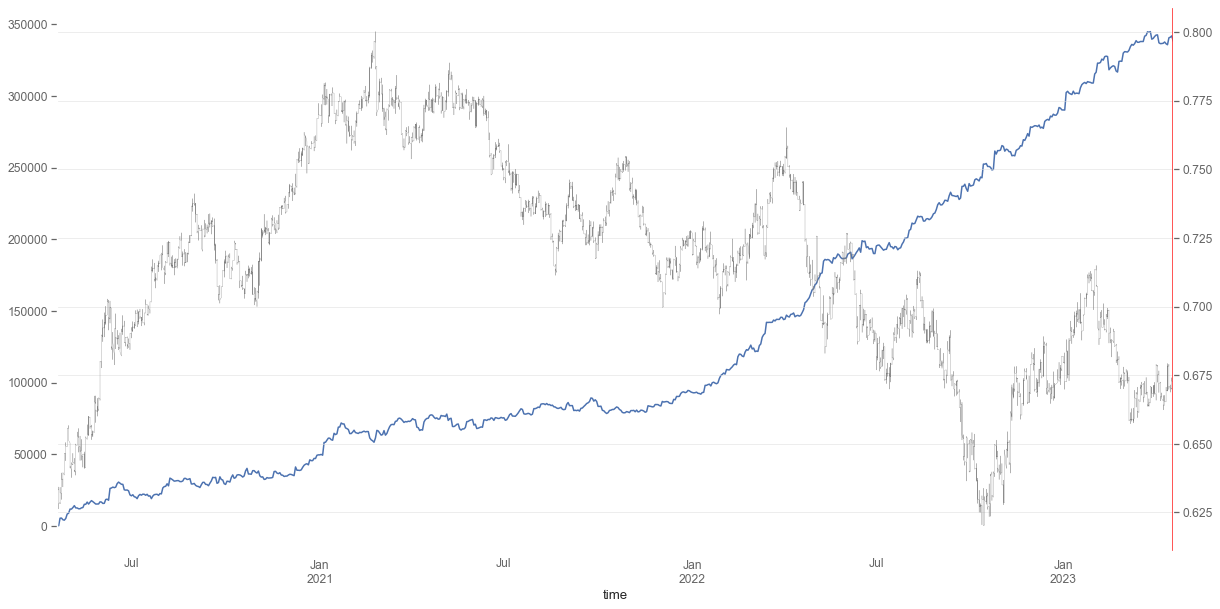

                           Strategy
-------------------------  ----------
Start Period               2020-04-21
End Period                 2023-04-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          337.91%
CAGR﹪                     63.75%

Sharpe                     3.18
Prob. Sharpe Ratio         100.0%
Smart Sharpe               3.11
Sortino                    6.09
Smart Sortino              5.96
Sortino/√2                 4.31
Smart Sortino/√2           4.21
Omega                      1.89

Max Drawdown               -8.85%
Longest DD Days            81
Volatility (ann.)          15.86%
Calmar                     7.2
Skew                       1.23
Kurtosis                   6.84

Expected Daily %           0.2%
Expected Monthly %         4.07%
Expected Yearly %          44.66%
Kelly Criterion            26.61%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.44%
Expected Shortfall (cVaR)  -1.44%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-06-19,2020-07-07,2020-08-07,49,-8.853844,-8.835256
2,2021-01-25,2021-02-24,2021-03-17,51,-7.825499,-7.223439
3,2021-05-07,2021-05-20,2021-07-08,62,-6.249750,-5.819811
4,2021-09-27,2021-10-11,2021-12-17,81,-5.725821,-5.495943
5,2020-10-23,2020-11-09,2020-12-09,47,-5.488501,-5.362981


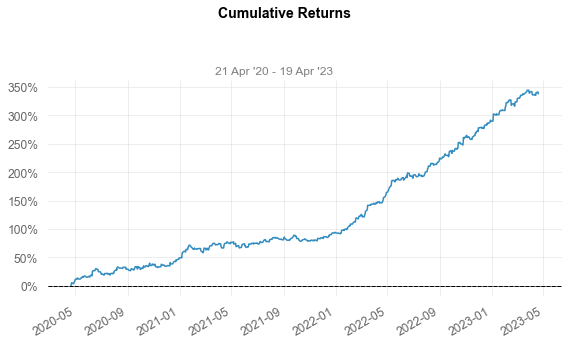

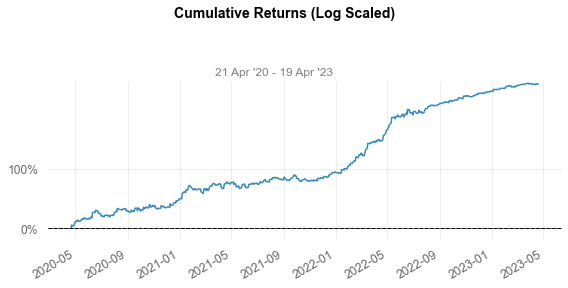

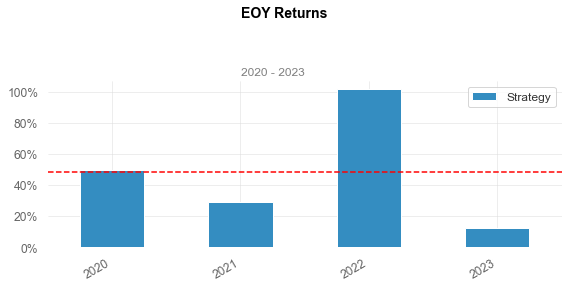

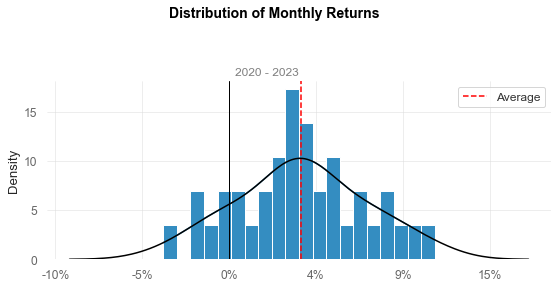

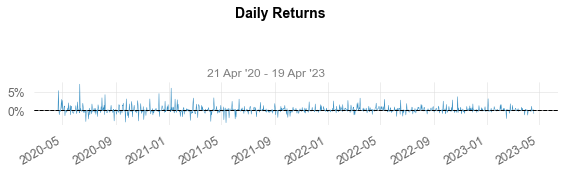

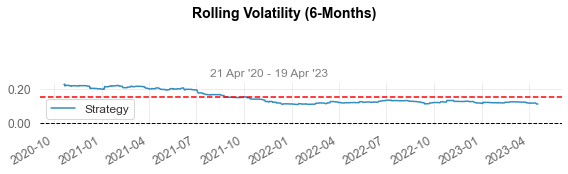

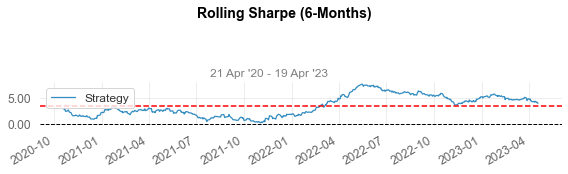

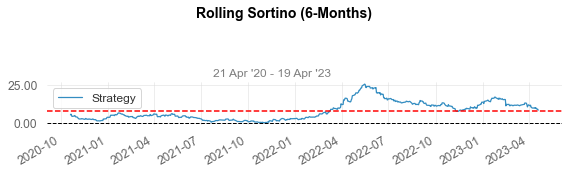

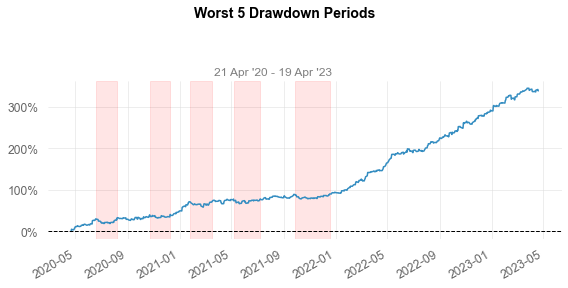

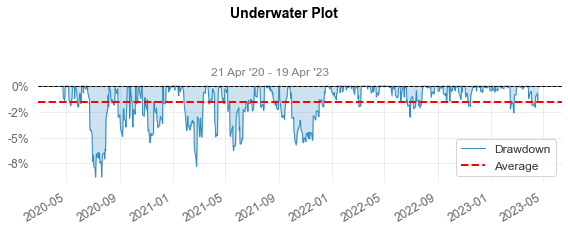

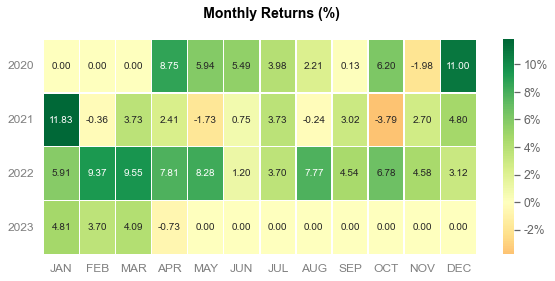

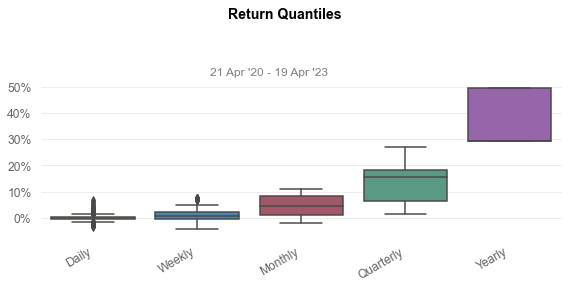

In [7]:
%time

ls_mercati=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD"]


for simbolo in ls_mercati:

    ###################### TUO CARICO DATI ######################
    #simbolo="EURNZD"
    #time_frame = "H1"
    #start_test = str(datetime.datetime.now().date() - relativedelta(years=3))
    #end_test = str(datetime.datetime.now().date())
    #dataset=readdata_MT5_Date(simbolo,time_frame,path,start_test,end_test)
    #dataset=dataset[dataset.index.dayofweek<5]
    #dataset.close.plot(figsize=(20,10),grid=True,title=simbolo)
    #plt.show()
    ##################################################################
    
    rules, rule_formulas = apply_indicator_base(dataset)
    
    os.chdir(r"C:\Users\Administrator\TEST")
    %run ./Genetic_Lib.ipynb

    #################################################################################################################


    MAX_STD_DAILY = 2000

    check_max_std_daily=0

    cnt_add = 0

    ls_dir = ["long" , "short"]
    start_direction = "long"

    secondary_equity = []
    System = pd.DataFrame()
    System_operations = pd.DataFrame()

    while True:
        if check_max_std_daily < MAX_STD_DAILY:

            clear_output(wait=True)

            INSTRUMENT = 2  # 1: equity, 2: future, 3: crypto/forex
            CAPITAL = 1  # money per trade (case INSTRUMENTS = 1,3) or number of contracts (case INSTRUMENTS = 2)
            BIGPOINTVALUE = get_poin_values(path,simbolo)
            TICK = 0.0001
            COSTS_FIXED = 5
            Out_Of_Sample_pct = OOS(dataset,0)
            secondary_equity = check_secondary_equity(secondary_equity)

            START_SESSION = 2
            END_SESSION = 22
            TIME_EXIT = int(2+cnt_add)
            DIRECTION = start_direction

            POPULATION_SIZE = 100
            NUM_GENERATIONS = 10

            DNA_SIZE = 3
            BEST_DNA_RATIO = 0.2
            CROSS_DNA_RATIO = 0.2
            MUTATION_PROB = 0.5

            # Profit
            # AvgTrade
            # ProfitFactor
            # GrossProfit
            # Profit/MaxDrawDown
            # AvgTrade/MaxDrawDown
            # KestnerRatio
            # StandardDeviation
            # SQN
            FITNESS_FUNCTION = "SQN"
            MIN_OPERATIONS = 150

            INSTABILITY_FACTOR = 0
            GSA = 0
            GSA_SPLIT = 20

            # Conversioni per Numba
            rules_array = rules.copy().values.T
            cond_idx = rules.index.hour.values
            cond_date = rules.index.values
            price = dataset.open 

            population = first_generation()

            OOS_date = dataset.iloc[:Out_Of_Sample_pct].index[-1]

            %time best_dnas = evolution()

            last_dna = best_dnas[-1]

            ######################################### backtest

            entry_rule = dna_formula(last_dna)
            exit_rule = '(dataset.index.hour==21)'
            bigpointvalue = BIGPOINTVALUE
            tick = 0.0001
            level='dataset.close.shift(1)'
            tipo_ordine = 'market'
            exit_bars = TIME_EXIT
            TP=0
            SL=0
            costi = COSTS_FIXED
            ADD_RULE_CONDITION = '(dataset.index.hour>=1) & (dataset.index.hour<=21)'
            direzione = DIRECTION
            tradelist = BK_Plus(dataset,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)
            report(tradelist.operations,100000,1,"")

            #####################################################

            System_operations = pd.concat([System_operations,tradelist.operations],axis=1).fillna(0)
            strategy_dna = dna_formula(last_dna)
            strategy_Exit = TIME_EXIT


            x=tradelist.operations.copy()
            x=x[x!=0]
            tp_strategy=int(x.quantile(0.95))
            sl_strategy=int(abs(x.quantile(0.05))) 
            print(tp_strategy,sl_strategy)


            info_strategy=pd.DataFrame([BIGPOINTVALUE,TICK,simbolo,"UTC",0,time_frame,start_test,end_test,START_SESSION,END_SESSION,COSTS_FIXED,DIRECTION,"market",strategy_dna,strategy_Exit,level,ADD_RULE_CONDITION,tp_strategy,sl_strategy,exit_rule]).T
            info_strategy.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION","TP","SL","exit_rule"])

            System = pd.concat([System,info_strategy]).fillna(0)

            ######################################################

            new_name=[]
            for e in range(len(System)):
                new_name.append("Strategy_"+str(e))
            System_operations.columns=new_name

            ######################################################

            System_operations.index = pd.to_datetime(System_operations.index)
            ptf = System_operations.resample("D").sum()
            ptf = ptf[ptf.index.dayofweek<5].dropna()
            w = ptf.std().to_frame()
            w.columns = (["STD"])
            w["STD_MAX"] = w.STD.max()
            w["Size"] = w.STD_MAX / w.STD

            ######################################################

            for e in ptf.columns:
                size = float(w.Size[w.index == e])
                ptf[e] = ptf[e]*size

            ######################################################

            check_max_std_daily = ptf.sum(axis=1)
            check_max_std_daily = check_max_std_daily[check_max_std_daily!=0]
            check_max_std_daily = check_max_std_daily.std()

            ######################################################

            cnt_add = cnt_add+0.5
            if start_direction == "long":
                start_direction = "short"
            else:
                start_direction = "long"

            secondary_equity = ptf.sum(axis=1).to_frame()
            secondary_equity = secondary_equity.reset_index().to_numpy()
        else:
            break

    clear_output(wait=True)        
    System.index = w.index
    System["Size"] = round(w.Size,2)

    import os
    os.chdir(r"C:\Users\Administrator\TEST\Strategy")
    import uuid
    idz = uuid.uuid1()
    save_as = simbolo+"_system_"+time_frame+"_"+str(idz)+".csv"
    System.to_csv(save_as)

    ptf.cumsum().plot(figsize=(20,10),grid=True)
    dataset.close.plot(secondary_y=True,color="grey",linewidth=0.3)
    plt.axvline(x=OOS_date,color="red")
    plt.show()

    ptf.sum(axis=1).cumsum().plot(figsize=(20,10),grid=True)
    dataset.close.plot(secondary_y=True,color="grey",linewidth=0.3)
    plt.axvline(x=OOS_date,color="red")
    plt.show()

    report(ptf.sum(axis=1),100000,2,"")